# Cybersecurity Exam
Palli Nicola - nicola.palli@studio.unibo.it
Piergentili Giacomo - giacomo.piergentili2@studio.unibo.it

This notebook contains all the code used to test several Machine Learning models, includeing:
- a Decision Tree model;
- a Naive Bayes model;
- a Linear Perceptron model;
- a Linear SVC model;
- a K-nn model;
- an Ensemble model;
- a Convolutional NN.

All models are trained and validated by using the NSL-KDD Training dataset, and tested on NSL-KDD Test dataset. In order to test the efficiency of different dimensionality reduction techniques, all the experiments are replicated using a reduced version of the two datasets.

## Libraries and functions

In [1]:
import urllib
import zipfile
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, MinMaxScaler
from tqdm import tqdm
from pathlib import Path
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv1D, Dropout, MaxPool1D, Activation, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import json
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [2]:
def centroid(X, y):
    unique_classes = np.unique(y)
    centroids = []
    
    for cls in unique_classes:
        points_for_class = X[y == cls]
        centroid_for_class = np.mean(points_for_class, axis=0)
        centroids.append(centroid_for_class)
    return np.array(centroids)

def cluster_accuracy(x, y_true, centroids,out='accuracy'):
    distance = np.linalg.norm(x[:, np.newaxis, :] - centroids, axis=2)**2
    indici_centroidi = np.argmin(distance, axis=1)
    if out=='accuracy':
        accuracy = np.sum(indici_centroidi == y_true) / len(y_true)
        return accuracy
    elif out=='DR':
        DR = np.sum((indici_centroidi == y_true)*(y_true!=0))/np.sum(y_true!=0)
        return DR
    elif out=='FPR':
        FPR = np.sum((y_true==0)*(indici_centroidi!=y_true))/np.sum(y_true==0)
        return FPR
    else:
        raise ValueError

def print_results(model,X_test,y_test):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

def flatten(y,y_pred,classes=True):
    y = y.reshape(-1, y.shape[-1])
    y_pred = y_pred.reshape(-1, y_pred.shape[-1])
    if classes:
        y = np.argmax(y, axis=-1)
        y_pred = np.argmax(y_pred, axis=-1)
    return y,y_pred

def F1(y_true,y_pred,out="F1"):
    y_pred_1H = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=y_pred.shape[-1])
    TP=0
    FP=0
    FN=0
    TN=0
    ignored=0.
    R=[]
    P=[]
    F1=[]
    if out=="F1":
        for i in range(y_true.shape[-1]):
            TP = K.sum(y_pred_1H[:,i] * y_true[:,i])
            FP = K.sum(y_pred_1H[:,i]) - TP
            FN = tf.cast(K.sum(y_true[:,i]), dtype=tf.float32) - TP
            if (TP+FP==0) or (TP+FN==0):
                if (TP==0) and (FP==0) and (FN==0):
                    ignored += 1
                p = TP
                r = TP
                f = TP
            else:
                p = TP/(TP+FP)
                r = TP/(TP+FN)
                if p==0 or r==0:
                    f = p*r
                else:
                    f = 2*r*p/(r+p)
            R.append(r)
            P.append(p)
            F1.append(f)
        macroF1 = sum(F1)/(len(F1)-ignored)
        return macroF1
    
    else:
        for i in range(1,y_true.shape[-1]):
            TP += K.sum(y_pred_1H[:,i] * y_true[:,i])
            FN += tf.cast(K.sum(y_true[:,i]), dtype=tf.float32)

        TN = K.sum(y_pred[:,0] * y_true[:,0])
        FN -= TP
        FP = tf.cast(K.sum(y_true[:,0]), dtype=tf.float32) - TN
        if out=='DR':
            if TP+FN>0:
                return TP/(TP+FN)
            else:
                return 1.0
        elif out=='FPR':
            if FP+TN>0:
                return FP/(FP+TN)
            else:
                return 1.0
        elif out=='F1error':
            if (TP+FP)==0 or (TP+FN)==0:
                if (TP==0)and(FP==0)and(FN==0):
                    return 1.0
                else:
                    return 0.0
            else:
                p=TP/(TP+FP)
                r=TP/(TP+FN)
                return 2*p*r/(p+r)
        else:
            raise ValueError

def DR(y_true,y_pred):
    return F1(y_true,y_pred,out='DR')

def FPR(y_true,y_pred):
    return F1(y_true,y_pred,out='FPR')

def simpleF1(y_true,y_pred):
    return F1(y_true,y_pred,out='F1error')

## Dataset analysis and pre-processing

In [3]:
df_train = pd.read_csv('KDDTrain+.txt',header=None,names=[str(i) for i in range(43)])
df_test = pd.read_csv('KDDTest+.txt',header=None,names=[str(i) for i in range(43)])
df_train = df_train.iloc[:, :-1]
df_test = df_test.iloc[:, :-1]
df_train

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune


The two datasets contain a several number of possible anomalies. In this notebook they are grouped in 5 main categories:
- normal events;
- Probes;
- DoS;
- U2R;
- R2L.

In [4]:
df_train['41'] = df_train['41'].replace(['normal'], 0)                                                                                    #NORMAL
df_test['41'] = df_test['41'].replace(['normal'], 0)
df_train['41'] = df_train['41'].replace(['ipsweep', 'nmap', 'portsweep', 'satan','mscan','saint'], 1)              #PROBE
df_test['41'] = df_test['41'].replace(['ipsweep', 'nmap', 'portsweep', 'satan','mscan','saint'], 1)
df_train['41'] = df_train['41'].replace([ 'back', 'land', 'neptune', 'pod', 'smurf', 'teardrop','apache2','worm','processtable','udpstorm','mailbomb'], 2)  #DoS
df_test['41'] = df_test['41'].replace([ 'back', 'land', 'neptune', 'pod', 'smurf', 'teardrop','apache2','worm','processtable','udpstorm','mailbomb'], 2)
df_train['41'] = df_train['41'].replace(['buffer_overflow', 'loadmodule', 'rootkit','ps','sqlattack','xterm','perl'], 3)                                                  #U2R
df_test['41'] = df_test['41'].replace(['buffer_overflow', 'loadmodule', 'rootkit','ps','sqlattack','xterm','perl'], 3)
df_train['41'] = df_train['41'].replace(['ftp_write', 'guess_passwd', 'imap', 'multihop','phf','spy', 'warezclient', 'warezmaster','httptunnel','named','sendmail','xsnoop','snmpgetattack','snmpguess','xlock'], 4)   #R2L
df_test['41'] = df_test['41'].replace(['ftp_write', 'guess_passwd', 'imap', 'multihop','phf','spy', 'warezclient', 'warezmaster','httptunnel','named','sendmail','xsnoop','snmpgetattack','snmpguess','xlock'], 4)
df_train.head()
errors={0:'normal',1:'probe',2:'DoS',3:'U2R',4:'R2L'}

C:\Users\utente\AppData\Local\Temp\ipykernel_18872\3462635711.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['41'] = df_train['41'].replace(['ftp_write', 'guess_passwd', 'imap', 'multihop','phf','spy', 'warezclient', 'warezmaster','httptunnel','named','sendmail','xsnoop','snmpgetattack','snmpguess','xlock'], 4)   #R2L
C:\Users\utente\AppData\Local\Temp\ipykernel_18872\3462635711.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['41'] = df_test['41'].replace(['ftp_write', 'guess_passwd', 'imap', 'multihop',

During the pre-processing computation, all the numerical features are normalized using a MinMax Scaler. The categorical features are encoded using a One Hot Encoder.

In [5]:
scaler = MinMaxScaler()
for i in [str(k) for k in range(41) if k!=1 and k!=2 and k!=3]:
    df_train[[i]] = scaler.fit_transform(df_train[[i]])
    df_test[[i]]=scaler.transform(df_test[[i]])

In [6]:
for i in ['1','2','3']:
    columns_to_encode=[i]
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)
    encoded_columns = categorical_transformer.fit_transform(df_train[columns_to_encode])
    new_columns = df_train[i].unique()
    print(len(new_columns))
    encoded_df = pd.DataFrame(encoded_columns, columns=new_columns, index=df_train.index)
    df_train[new_columns] = encoded_df
    df_train = df_train.drop(columns=columns_to_encode)

    encoded_columns = categorical_transformer.transform(df_test[columns_to_encode])
    encoded_df = pd.DataFrame(encoded_columns, columns=new_columns, index=df_test.index)
    df_test[new_columns] = encoded_df
    df_test = df_test.drop(columns=columns_to_encode)

colonna_41 = df_train.pop('41')
df_train['y'] = colonna_41
colonna_41 = df_test.pop('41')
df_test['y'] = colonna_41


df_train.head()

3
70


C:\Users\utente\AppData\Local\Temp\ipykernel_18872\1855122880.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[new_columns] = encoded_df
C:\Users\utente\AppData\Local\Temp\ipykernel_18872\1855122880.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[new_columns] = encoded_df
C:\Users\utente\AppData\Local\Temp\ipykernel_18872\1855122880.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

11


C:\Users\utente\AppData\Local\Temp\ipykernel_18872\1855122880.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[new_columns] = encoded_df
C:\Users\utente\AppData\Local\Temp\ipykernel_18872\1855122880.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[new_columns] = encoded_df
C:\Users\utente\AppData\Local\Temp\ipykernel_18872\1855122880.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

,0,4,5,6,7,8,9,10,11,12,...,REJ,RSTR,SH,RSTO,S1,RSTOS0,S3,S2,OTH,y
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


<AxesSubplot:>

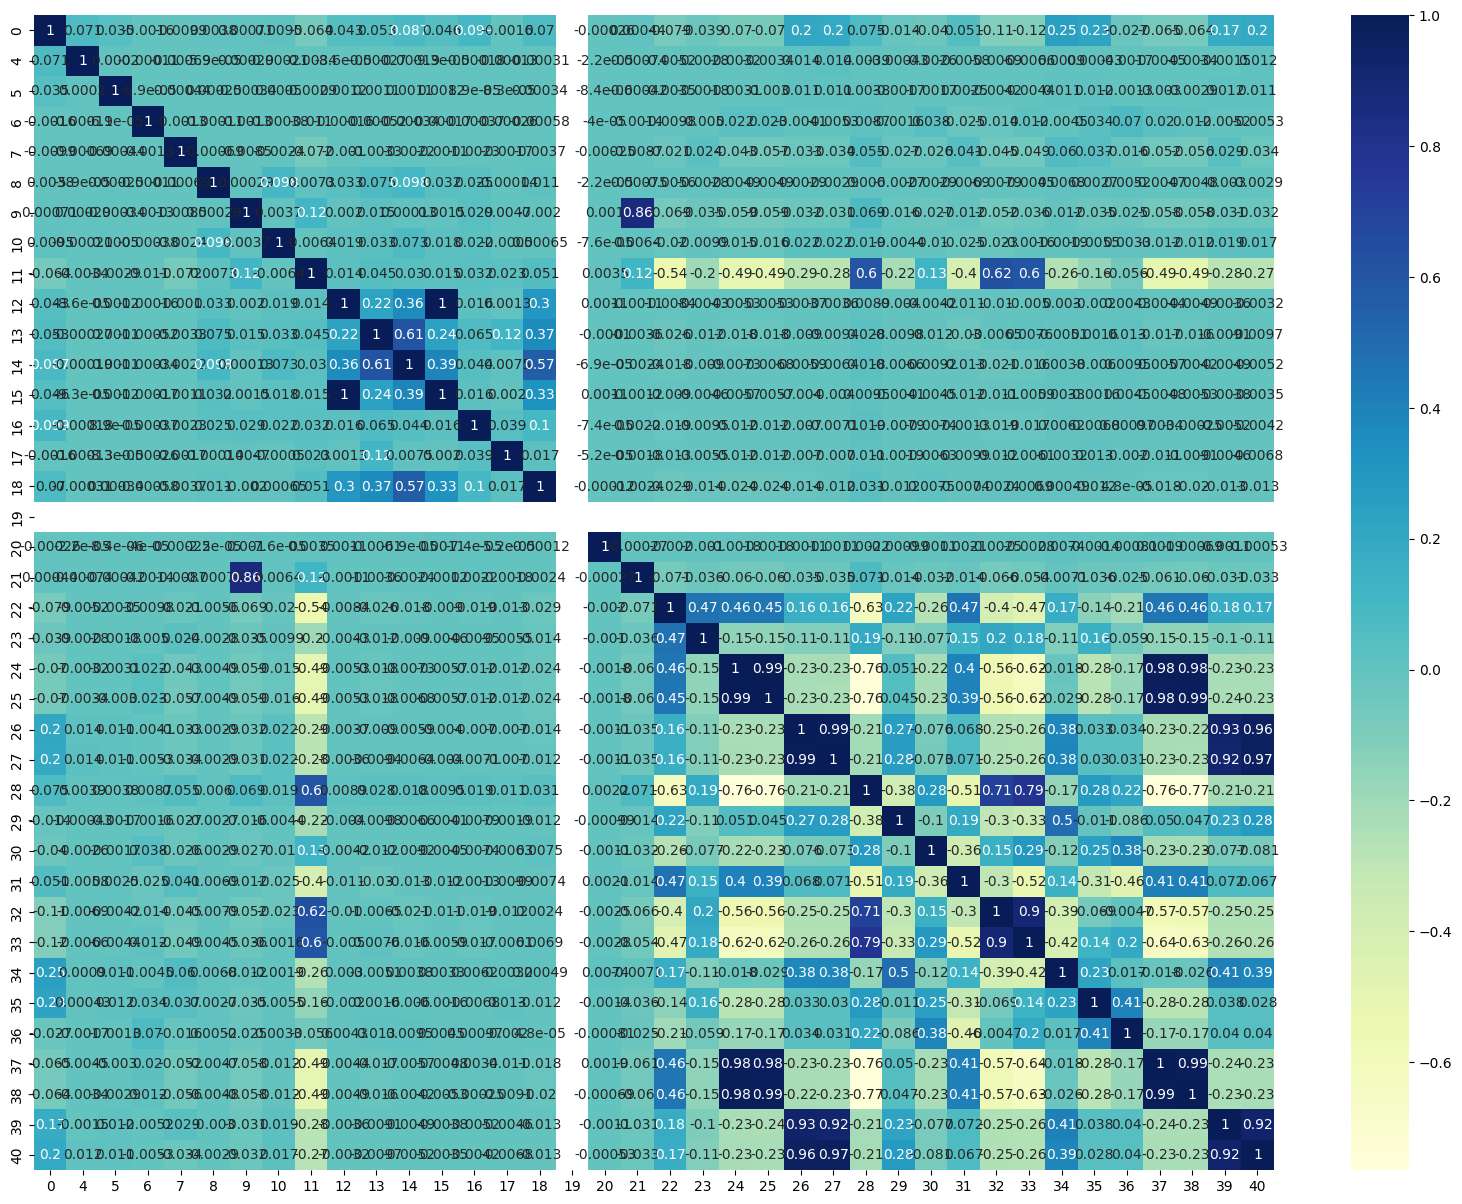

In [7]:
corr = df_train[[str(i) for i in range(41) if i!=1 and i!=2 and i!=3]].corr()                                             # CORRELATION MATRIX

plt.figure(figsize=(20, 15))
sns.heatmap(corr, cmap="YlGnBu", annot=True)

Since feature 12 and 15 has correlation 1 and feature 19 has always value 0, column 12 and 19 are deleted

In [8]:
df_train = df_train.drop(columns=['12', '19'])
df_test = df_test.drop(columns=['12', '19'])

In [9]:
x_train = df_train.iloc[:,:-1].values
y_train = df_train.iloc[:, -1].values
x_test = df_test.iloc[:,:-1].values
y_test = df_test.iloc[:, -1].values
print(x_train.shape)
print(x_test.shape)

(125973, 120)
(22544, 120)


## Dimensionality Reduction

In order to produce a smaller dataset, PCA and LDA algorithms are used. These methods can be useful to extract the most relevant informations to detect threats.

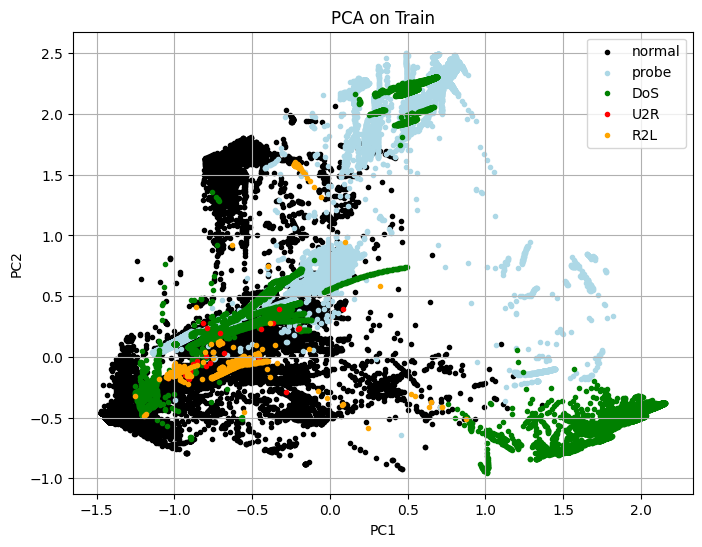

In [11]:
pca = PCA(n_components=2)

x_train_2d=pca.fit_transform(x_train)
#x_test_2d=pca.transform(x_test)

colori = ['black', 'lightblue', 'green', 'red', 'orange']
colori_classe = {classe: colore for classe, colore in zip([0,1,2,3,4], colori)}

plt.figure(figsize=(8, 6))

for classe in [0,1,2,3,4]:
    indici_train = (y_train == classe)
    #indici_test = (y_test == classe)
    plt.scatter(x_train_2d[indici_train, 0], x_train_2d[indici_train, 1], c=colori_classe[classe], marker='.', label=errors[classe])
    #plt.scatter(x_test_2d[indici_test, 0], x_test_2d[indici_test, 1], c=colori_classe[classe], marker='.')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA on Train')
plt.legend()
plt.grid(True)
#plt.xlim(-50000, 25000)
#plt.ylim(-25000, 60000)
plt.show()

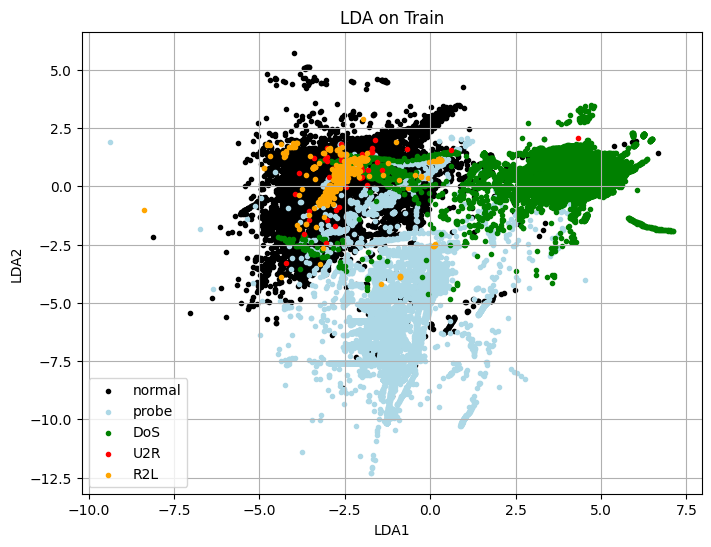

In [12]:
lda = LinearDiscriminantAnalysis(n_components=2)

x_train_2d=lda.fit_transform(x_train,y_train)
#x_test_2d=lda.transform(x_test)

colori = ['black', 'lightblue', 'green', 'red', 'orange']
colori_classe = {classe: colore for classe, colore in zip([0,1,2,3,4], colori)}

plt.figure(figsize=(8, 6))

for classe in [0,1,2,3,4]:
    indici_train = (y_train == classe)
    #indici_test = (y_test == classe)
    plt.scatter(x_train_2d[indici_train, 0], x_train_2d[indici_train, 1], c=colori_classe[classe], marker='.', label=errors[classe])
    #plt.scatter(x_test_2d[indici_test, 0], x_test_2d[indici_test, 1], c=colori_classe[classe], marker='.')

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('LDA on Train')
plt.legend()
plt.grid(True)
plt.show()

By observing the results below, we decided to use LDA with 4 components to create a reduced version fo the train and test datasets.

Computing 10 dimensions...
Computing 20 dimensions...
Computing 30 dimensions...
Computing 40 dimensions...
Computing 50 dimensions...
Computing 60 dimensions...
Computing 70 dimensions...
Computing 80 dimensions...
Computing 90 dimensions...
Computing 100 dimensions...
Computing 110 dimensions...
Computing 120 dimensions...


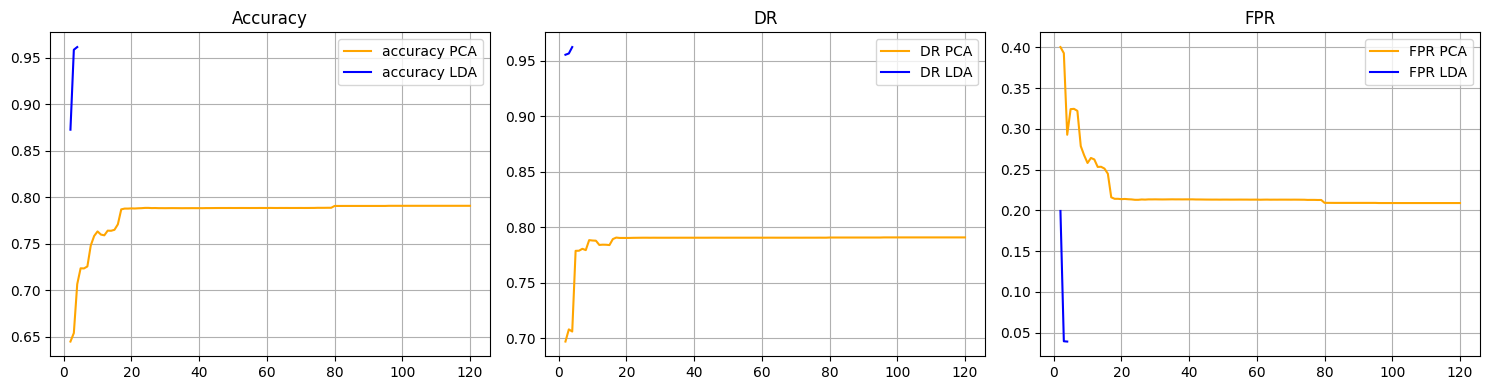

In [13]:
Lacc=[]
Pacc=[]
LDR=[]
PDR=[]
LFPR=[]
PFPR=[]
limit=x_train.shape[-1]
for i in range(2,limit+1):
    pca = PCA(n_components=i)
    x_train_pca=pca.fit_transform(x_train)
    Cpca = centroid(x_train_pca,y_train)
    Pacc.append(cluster_accuracy(x_train_pca,y_train,Cpca))
    PDR.append(cluster_accuracy(x_train_pca,y_train,Cpca,out='DR'))
    PFPR.append(cluster_accuracy(x_train_pca,y_train,Cpca,out='FPR'))
    try:
        lda = LinearDiscriminantAnalysis(n_components=i)
        x_train_lda=lda.fit_transform(x_train,y_train)
        Clda = centroid(x_train_lda,y_train)
        Lacc.append(cluster_accuracy(x_train_lda,y_train,Clda))
        LDR.append(cluster_accuracy(x_train_lda,y_train,Clda,out='DR'))
        LFPR.append(cluster_accuracy(x_train_lda,y_train,Clda,out='FPR'))
    except ValueError:
        pass
    if i%10==0:
        print(f"Computing {i} dimensions...")
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(np.arange(2, limit + 1), Pacc, c='orange', label='accuracy PCA')
axs[0].plot(np.arange(2, 5), Lacc, c='blue', label='accuracy LDA')
axs[0].set_title('Accuracy')
axs[0].grid()
axs[0].legend()

axs[1].plot(np.arange(2, limit + 1), PDR, c='orange', label='DR PCA')
axs[1].plot(np.arange(2, 5), LDR, c='blue', label='DR LDA')
axs[1].set_title('DR')
axs[1].grid()
axs[1].legend()

axs[2].plot(np.arange(2, limit + 1), PFPR, c='orange', label='FPR PCA')
axs[2].plot(np.arange(2, 5), LFPR, c='blue', label='FPR LDA')
axs[2].set_title('FPR')
axs[2].grid()
axs[2].legend()

plt.tight_layout()
plt.show()

In [10]:
lda = LinearDiscriminantAnalysis(n_components=4)
x_train_scaled = lda.fit_transform(x_train,y_train)
x_test_scaled = lda.transform(x_test)

## Machine Learning

The five ML models are initialized using the best hyper-parameters found by Grid Search on validation.

In [11]:
model_lbls = [
              'dt', 
              'nb', 
              'lp', 
              'svc', 
              'knn',
            ]

# Set the parameters by cross-validation
tuned_param_dt = [{'max_depth': [i for i in range(1,20)]}]
tuned_param_nb = [{'var_smoothing': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-07, 1e-8, 1e-9, 1e-10]}]
tuned_param_lp = [{'early_stopping': [True]}]
tuned_param_svc = [{'C': [1, 10, 20]}]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

models = {
    'dt': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(), 
           'param': tuned_param_dt,
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': tuned_param_nb
          },
    'lp': {'name': 'Linear Perceptron',
           'estimator': Perceptron(),
           'param': tuned_param_lp,
          },
    'svc':{'name': 'Support Vector',
           'estimator': LinearSVC(), 
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
        
    }
}

scores = ['f1_macro']

The results display the performance of each model on both the test and validation sets. Notably, the test results indicate inferior performance across all models.

In [12]:
results_short = {}
best_models = {}

for score in scores:
    print('='*40)
    print("# Tuning hyper-parameters for %s" % score)
    print()

    #'%s_macro' % score ## is a string formatting expression
    # the parameter after % is substituted in the string placeholder %s
    for m in model_lbls:
        print('-'*40)
        print("Trying model {}".format(models[m]['name']))
        clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                           scoring=score, 
                           return_train_score = False,
                           n_jobs = 2, # this allows using multi-cores
                           )
        best_models[m]=clf
        clf.fit(x_train, y_train)
        print_results(clf,x_test,y_test)
        results_short[m] = clf.best_score_
    print("Summary of results for {} on validation".format(score))
    print("Estimator")
    for m in results_short.keys():
        print("{}\t - score: {:4.2}".format(models[m]['name'], results_short[m]))

# Tuning hyper-parameters for f1_macro

----------------------------------------
Trying model Decision Tree
Best parameters set found on train set:

{'max_depth': 18}

Grid scores on train set:

0.354 (+/-0.001) for {'max_depth': 1}
0.492 (+/-0.004) for {'max_depth': 2}
0.549 (+/-0.002) for {'max_depth': 3}
0.571 (+/-0.002) for {'max_depth': 4}
0.582 (+/-0.001) for {'max_depth': 5}
0.588 (+/-0.001) for {'max_depth': 6}
0.593 (+/-0.002) for {'max_depth': 7}
0.665 (+/-0.042) for {'max_depth': 8}
0.696 (+/-0.012) for {'max_depth': 9}
0.755 (+/-0.005) for {'max_depth': 10}
0.812 (+/-0.041) for {'max_depth': 11}
0.807 (+/-0.046) for {'max_depth': 12}
0.825 (+/-0.036) for {'max_depth': 13}
0.837 (+/-0.053) for {'max_depth': 14}
0.848 (+/-0.042) for {'max_depth': 15}
0.845 (+/-0.047) for {'max_depth': 16}
0.863 (+/-0.034) for {'max_depth': 17}
0.873 (+/-0.044) for {'max_depth': 18}
0.871 (+/-0.045) for {'max_depth': 19}

Detailed classification report for the best parameter set:

The model is

c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters set found on train set:

{'C': 10}

Grid scores on train set:

0.800 (+/-0.083) for {'C': 1}
0.817 (+/-0.072) for {'C': 10}
0.814 (+/-0.072) for {'C': 20}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.65      0.93      0.77      9711
           1       0.68      0.66      0.67      2421
           2       0.96      0.80      0.88      7460
           3       0.82      0.13      0.23        67
           4       0.51      0.03      0.06      2885

    accuracy                           0.74     22544
   macro avg       0.72      0.51      0.52     22544
weighted avg       0.74      0.74      0.70     22544


----------------------------------------
Trying model K Nearest Neighbor
Best parameters set found on train set:

{'n_neighbors': 1}

Grid scores on train set:

0.890 (+/-0.050) for {'n_n

The same procedure is applied on the reduced datasets.

In [33]:
results_short = {}
best_models_scaled = {}

for score in scores:
    print('='*40)
    print("# Tuning hyper-parameters for %s" % score)
    print()

    for m in model_lbls:
        print('-'*40)
        print("Trying model {}".format(models[m]['name']))
        clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                           scoring=score, 
                           return_train_score = False,
                           n_jobs = 2, # this allows using multi-cores
                           )
        clf.fit(x_train_scaled, y_train)
        best_models_scaled[m]=clf
        print_results(clf,x_test_scaled,y_test)
        results_short[m] = clf.best_score_
    print("Summary of results for {}".format(score))
    print("Estimator")
    for m in results_short.keys():
        print("{}\t - score: {:4.2}".format(models[m]['name'], results_short[m]))

# Tuning hyper-parameters for f1_macro

----------------------------------------
Trying model Decision Tree
Best parameters set found on train set:

{'max_depth': 19}

Grid scores on train set:

0.377 (+/-0.000) for {'max_depth': 1}
0.571 (+/-0.002) for {'max_depth': 2}
0.705 (+/-0.004) for {'max_depth': 3}
0.723 (+/-0.004) for {'max_depth': 4}
0.815 (+/-0.132) for {'max_depth': 5}
0.809 (+/-0.102) for {'max_depth': 6}
0.845 (+/-0.059) for {'max_depth': 7}
0.841 (+/-0.046) for {'max_depth': 8}
0.849 (+/-0.052) for {'max_depth': 9}
0.848 (+/-0.044) for {'max_depth': 10}
0.842 (+/-0.036) for {'max_depth': 11}
0.849 (+/-0.047) for {'max_depth': 12}
0.842 (+/-0.033) for {'max_depth': 13}
0.845 (+/-0.041) for {'max_depth': 14}
0.847 (+/-0.057) for {'max_depth': 15}
0.844 (+/-0.087) for {'max_depth': 16}
0.847 (+/-0.060) for {'max_depth': 17}
0.847 (+/-0.059) for {'max_depth': 18}
0.851 (+/-0.063) for {'max_depth': 19}

Detailed classification report for the best parameter set:

The model is

c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters set found on train set:

{'C': 1}

Grid scores on train set:

0.647 (+/-0.010) for {'C': 1}
0.635 (+/-0.061) for {'C': 10}
0.633 (+/-0.055) for {'C': 20}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.66      0.96      0.78      9711
           1       0.65      0.66      0.66      2421
           2       0.94      0.75      0.83      7460
           3       0.86      0.09      0.16        67
           4       0.17      0.00      0.00      2885

    accuracy                           0.73     22544
   macro avg       0.65      0.49      0.49     22544
weighted avg       0.69      0.73      0.68     22544


----------------------------------------
Trying model K Nearest Neighbor
Best parameters set found on train set:

{'n_neighbors': 1}

Grid scores on train set:

0.885 (+/-0.055) for {'n_ne

## Ensembling Validation

Using the five ML models above, an ensembled model is initialized, using a Voting Classifier. The model predicts the 

In [13]:
stacking_classifier = VotingClassifier(
    estimators=[
        ('dt', best_models['dt']),
        ('nb', best_models['nb']),
        ('lp', best_models['lp']),
        ('knn', best_models['knn']),
        ('svc', best_models['svc']),
    ],
    voting='hard',
)

#stacking_classifier.fit(x_train, y_train)

In [31]:
y_pred_all = None
y_test_all = None
interval = len(x_train)//5
for i in range(0, 5):
    stacking_classifier.fit(np.delete(x_train, np.arange(i*interval,(i+1)*interval), axis=0), np.delete(y_train, np.arange(i*interval,(i+1)*interval), axis=0))
    y_pred = stacking_classifier.predict(x_train[(interval*i):(interval*(i+1))])
    y_pred_all = y_pred if y_pred_all is None else np.concatenate([y_pred_all, y_pred])
report = classification_report(y_train[:(interval*5)],y_pred_all)
print(report)

c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0


c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1


c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2


c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


3


c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


4
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     67341
           1       0.97      0.97      0.97     11656
           2       0.99      0.99      0.99     45926
           3       0.76      0.50      0.60        52
           4       0.87      0.85      0.86       995

    accuracy                           0.99    125970
   macro avg       0.92      0.86      0.88    125970
weighted avg       0.99      0.99      0.99    125970



The ensemble model is tested

In [48]:
stacking_classifier.fit(x_train, y_train)
y_pred = stacking_classifier.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.93      0.77      9711
           1       0.73      0.68      0.70      2421
           2       0.96      0.82      0.89      7460
           3       0.93      0.19      0.32        67
           4       0.32      0.02      0.03      2885

    accuracy                           0.75     22544
   macro avg       0.72      0.53      0.54     22544
weighted avg       0.72      0.75      0.71     22544



The same precedure is repeated by using the reduced dataset

In [34]:
stacking_classifier_scaled = VotingClassifier(
    estimators=[
        ('dt', best_models_scaled['dt']),
        ('nb', best_models_scaled['nb']),
        ('lp', best_models_scaled['lp']),
        ('knn', best_models_scaled['knn']),
        ('svc', best_models_scaled['svc']),
    ],
    voting='hard',
)

In [35]:
y_pred_all = None
y_test_all = None
interval = len(x_train_scaled)//5
for i in range(0, 5):
    stacking_classifier_scaled.fit(np.delete(x_train_scaled, np.arange(i*interval,(i+1)*interval), axis=0), np.delete(y_train, np.arange(i*interval,(i+1)*interval), axis=0))
    y_pred = stacking_classifier_scaled.predict(x_train_scaled[(interval*i):(interval*(i+1))])
    y_pred_all = y_pred if y_pred_all is None else np.concatenate([y_pred_all, y_pred])
report = classification_report(y_train[:(interval*5)],y_pred_all)
print(report)

c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\utente\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     67341
           1       0.95      0.92      0.93     11656
           2       0.99      0.98      0.98     45926
           3       0.70      0.40      0.51        52
           4       0.79      0.76      0.77       995

    accuracy                           0.97    125970
   macro avg       0.88      0.81      0.84    125970
weighted avg       0.97      0.97      0.97    125970



In [57]:
stacking_classifier_scaled.fit(x_train_scaled, y_train)
y_pred = stacking_classifier_scaled.predict(x_test_scaled)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.92      0.77      9711
           1       0.58      0.68      0.63      2421
           2       0.93      0.75      0.83      7460
           3       0.82      0.34      0.48        67
           4       0.78      0.01      0.01      2885

    accuracy                           0.72     22544
   macro avg       0.75      0.54      0.54     22544
weighted avg       0.76      0.72      0.68     22544



## Deep Neural Network
The last model is a simple convolutional neural network. The first three convolutional blocks extract the most relevant input features. The network ends with three dense layers wchich predict the probabilities of each output class.

In [ ]:
def CNN_model(input_shape=(1,120),verbose=False):
    # Definizione della rete
    input_layer = Input(shape=input_shape, name="input1")

    # Primo set di convoluzioni e max pooling
    conv1 = Conv1D(64, kernel_size=2, padding='same', name="conv1d1")(input_layer)
    print(f"conv1 {conv1.shape}") if verbose else ...
    act1 = Activation('relu', name="activation1")(conv1)
    print(f"act1 {act1.shape}") if verbose else ...
    max_pool1 = MaxPool1D(pool_size=2,padding='same',data_format='channels_first',strides=1)(act1)
    print(f"max1 {max_pool1.shape}") if verbose else ...
    flat1 = Flatten()(max_pool1)
    print(f"flat1 {flat1.shape}") if verbose else ...

    # Secondo set di convoluzioni e max pooling
    drop1 = Dropout(0.5)(max_pool1)
    conv2 = Conv1D(64, kernel_size=4, padding='same', name="conv1d2")(drop1)
    print(f"conv2 {conv2.shape}") if verbose else ...
    act2 = Activation('relu', name="activation2")(conv2)
    print(f"act2 {act2.shape}") if verbose else ...
    max_pool2 = MaxPool1D(pool_size=4,data_format='channels_first',padding='same',strides=1)(act2)
    print(f"max2 {max_pool2.shape}") if verbose else ...
    flat2 = Flatten()(max_pool2)
    print(f"flat2 {flat2.shape}") if verbose else ...

    # Terzo set di convoluzioni e max pooling
    drop2 = Dropout(0.5)(max_pool2)
    conv3 = Conv1D(128, kernel_size=8, padding='same', name="conv1d3")(drop2)
    print(f"conv3 {conv3.shape}") if verbose else ...
    act3 = Activation('relu', name="activation3")(conv3)
    print(f"act3 {act3.shape}") if verbose else ...
    max_pool3 = MaxPool1D(pool_size=8,data_format='channels_first',padding='same',strides=1)(act3)
    print(f"max3 {max_pool3.shape}") if verbose else ...
    flat3 = Flatten()(max_pool3)
    print(f"flat3 {flat3.shape}") if verbose else ...

    # Dense layers
    drop3 = Dropout(0.5)(flat3)
    dense1 = Dense(256, activation='relu', name="dense1")(drop3)
    drop4 = Dropout(0.5)(dense1)

    # Output layers
    dense2 = Dense(5, activation='softmax', name="dense2")(drop4)
    concat = concatenate([dense2, flat2, flat1], axis=1)
    print(f"concat {concat.shape}") if verbose else ...
    dense3 = Dense(5, activation='softmax', name="dense3")(concat)

    # Creazione del modello
    model = tf.keras.models.Model(inputs=input_layer, outputs=dense3)

    # Compilazione del modello
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[F1,DR,FPR,simpleF1])
    model.summary()

    return model


In [ ]:
tf.keras.backend.clear_session()
model = CNN_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 1, 120)]     0           []                               
                                                                                                  
 conv1d1 (Conv1D)               (None, 1, 64)        15424       ['input1[0][0]']                 
                                                                                                  
 activation1 (Activation)       (None, 1, 64)        0           ['conv1d1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1, 64)        0           ['activation1[0][0]']            
                                                                                              

                                                                                                  
 flatten_2 (Flatten)            (None, 128)          0           ['max_pooling1d_2[0][0]']        
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['flatten_2[0][0]']              
                                                                                                  
 dense1 (Dense)                 (None, 256)          33024       ['dropout_2[0][0]']              
                                                                                                  
 dropout_3 (Dropout)            (None, 256)          0           ['dense1[0][0]']                 
                                                                                                  
 dense2 (Dense)                 (None, 5)            1285        ['dropout_3[0][0]']              
          

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
x_train_tot, x_val_tot, y_train_tot, y_val_tot = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train_tot = x_train_tot.reshape(x_train_tot.shape[0], 1, x_train_tot.shape[-1])
x_val_tot = x_val_tot.reshape(x_val_tot.shape[0], 1, x_val_tot.shape[-1])
x_test_tot = x_test.reshape(x_test.shape[0], 1, x_test.shape[-1])
x_train_scaled, x_val_scaled, y_train_scaled, y_val_scaled = train_test_split(x_train_scaled, y_train, test_size=0.2, random_state=42)
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], 1, x_train_scaled.shape[-1])
x_val_scaled = x_val_scaled.reshape(x_val_scaled.shape[0], 1, x_val_scaled.shape[-1])
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[-1])

After 10 epochs, we obtain stable validation results. The observed metrics are Macro-F1, Detection Rate and False Positive Rate. F1 is computed also considering the 4 threat classes as a unique one (simple f1)

In [ ]:
b_size=32
model.fit(x_train_tot,y_train_tot,batch_size=b_size,steps_per_epoch=x_train_tot.shape[0]//b_size, epochs=10,validation_data=(x_val_tot, y_val_tot))

Epoch 1/10
3149/3149 [==============================] - 22s 7ms/step - loss: 0.0129 - F1: 0.9776 - DR: 0.9943 - FPR: 0.0067 - simpleF1: 0.9930 - val_loss: 0.0209 - val_F1: 0.9732 - val_DR: 0.9929 - val_FPR: 0.0078 - val_simpleF1: 0.9917
Epoch 2/10
3149/3149 [==============================] - 20s 6ms/step - loss: 0.0123 - F1: 0.9768 - DR: 0.9944 - FPR: 0.0064 - simpleF1: 0.9932 - val_loss: 0.0222 - val_F1: 0.9735 - val_DR: 0.9918 - val_FPR: 0.0058 - val_simpleF1: 0.9923
Epoch 3/10
3149/3149 [==============================] - 20s 6ms/step - loss: 0.0120 - F1: 0.9778 - DR: 0.9948 - FPR: 0.0061 - simpleF1: 0.9936 - val_loss: 0.0216 - val_F1: 0.9692 - val_DR: 0.9935 - val_FPR: 0.0083 - val_simpleF1: 0.9916
Epoch 4/10
3149/3149 [==============================] - 20s 6ms/step - loss: 0.0116 - F1: 0.9783 - DR: 0.9948 - FPR: 0.0060 - simpleF1: 0.9936 - val_loss: 0.0220 - val_F1: 0.9729 - val_DR: 0.9923 - val_FPR: 0.0067 - val_simpleF1: 0.9920
Epoch 5/10
3149/3149 [==============================

The CNN is tested on the test set

In [ ]:
test_results = model.evaluate(x_test_tot,y_test,batch_size=b_size,steps=x_test.shape[0]//b_size)
print(test_results)
y_pred = model.predict(x_test_tot)

704/704 [==============================] - 3s 4ms/step - loss: 3.2429 - F1: 0.6463 - DR: 0.6442 - FPR: 0.0342 - simpleF1: 0.7646
[3.2429025173187256, 0.6463211178779602, 0.6442229747772217, 0.034197594970464706, 0.764592707157135]
705/705 [==============================] - 3s 4ms/step


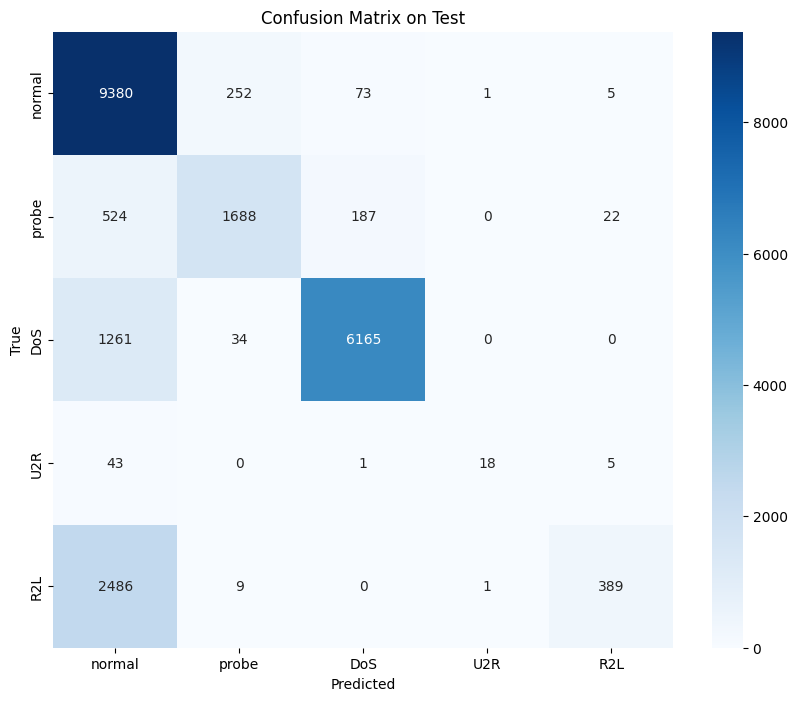

In [ ]:
plt.figure(figsize=(10, 8))
yCM, y_predCM = flatten(y_test,y_pred)
classes = np.unique(yCM)
cm = confusion_matrix(yCM, y_predCM)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['normal','probe','DoS','U2R','R2L'], yticklabels=['normal','probe','DoS','U2R','R2L'])

plt.title('Confusion Matrix on Test')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

All the procedure is repeated using the reduced datasets

In [ ]:
tf.keras.backend.clear_session()
scaled_model = CNN_model(input_shape=(1,4))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 1, 4)]       0           []                               
                                                                                                  
 conv1d1 (Conv1D)               (None, 1, 64)        576         ['input1[0][0]']                 
                                                                                                  
 activation1 (Activation)       (None, 1, 64)        0           ['conv1d1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1, 64)        0           ['activation1[0][0]']            
                                                                                              

In [ ]:
scaled_model.fit(x_train_scaled,y_train_scaled,batch_size=b_size,steps_per_epoch=x_train_scaled.shape[0]//b_size, epochs=10,validation_data=(x_val_scaled, y_val_scaled))

Epoch 1/10
3149/3149 [==============================] - 32s 9ms/step - loss: 0.1135 - F1: 0.9066 - DR: 0.9514 - FPR: 0.0489 - simpleF1: 0.9458 - val_loss: 0.1008 - val_F1: 0.9093 - val_DR: 0.9527 - val_FPR: 0.0418 - val_simpleF1: 0.9506
Epoch 2/10
3149/3149 [==============================] - 27s 9ms/step - loss: 0.0903 - F1: 0.9196 - DR: 0.9572 - FPR: 0.0392 - simpleF1: 0.9541 - val_loss: 0.0946 - val_F1: 0.9223 - val_DR: 0.9644 - val_FPR: 0.0481 - val_simpleF1: 0.9534
Epoch 3/10
3149/3149 [==============================] - 23s 7ms/step - loss: 0.0844 - F1: 0.9242 - DR: 0.9595 - FPR: 0.0371 - simpleF1: 0.9566 - val_loss: 0.0849 - val_F1: 0.9263 - val_DR: 0.9595 - val_FPR: 0.0368 - val_simpleF1: 0.9572
Epoch 4/10
3149/3149 [==============================] - 23s 7ms/step - loss: 0.0772 - F1: 0.9282 - DR: 0.9637 - FPR: 0.0346 - simpleF1: 0.9602 - val_loss: 0.0754 - val_F1: 0.9238 - val_DR: 0.9655 - val_FPR: 0.0330 - val_simpleF1: 0.9626
Epoch 5/10
3149/3149 [==============================

In [ ]:
test_results = scaled_model.evaluate(x_test_scaled,y_test,batch_size=b_size,steps=x_test.shape[0]//b_size)
print(test_results)
y_pred = scaled_model.predict(x_test_scaled)

704/704 [==============================] - 3s 5ms/step - loss: 1.7249 - F1: 0.5565 - DR: 0.5937 - FPR: 0.0703 - simpleF1: 0.7134
[1.7248516082763672, 0.5564741492271423, 0.5937070846557617, 0.07034926116466522, 0.7133678793907166]
705/705 [==============================] - 3s 4ms/step


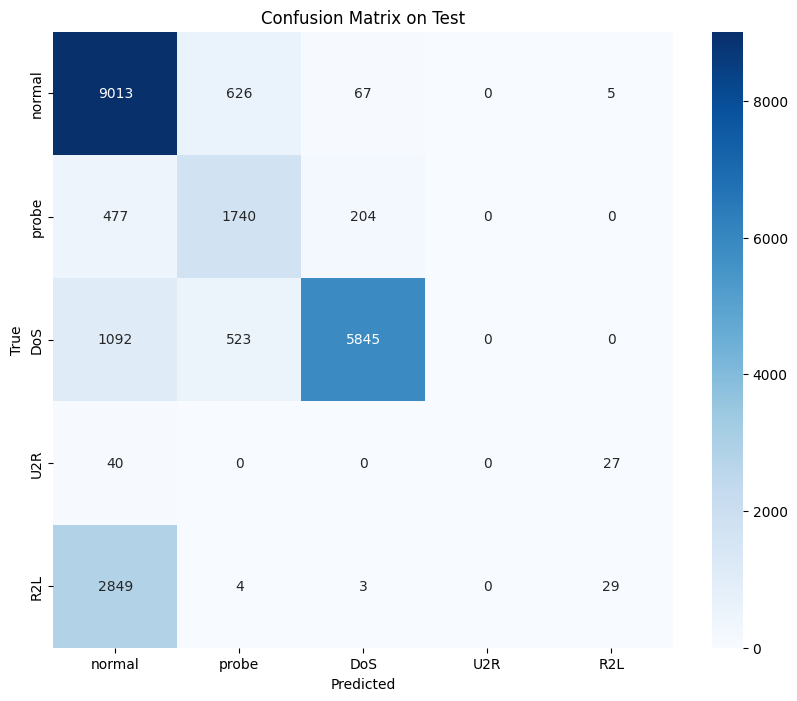

In [ ]:
plt.figure(figsize=(10, 8))
yCM, y_predCM = flatten(y_test,y_pred)
classes = np.unique(yCM)
cm = confusion_matrix(yCM, y_predCM)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['normal','probe','DoS','U2R','R2L'], yticklabels=['normal','probe','DoS','U2R','R2L'])

plt.title('Confusion Matrix on Test')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

## Conclusions

ML algorithms and more advanced deep neural networks have been tested as IDS using the NSL-KDD dataset. The results help understand the advantages, but especially the limitations of such algorithms within a sensitive context like cybersecurity. Although in some cases, the models did learn to identify anomalies and categorize their type, they struggled during the testing phase. The results show that the values of f1, DR, and FPR deteriorate drastically, moving from values of 0.97, 0.98, and 0.04 during validation to 0.56, 0.59, and 0.07 during testing. This demonstrates that such approaches can be flawed when faced with new and unknown cyber-attacks. The test set is indeed richer in types of threats unknown to the model during training. Moreover, focusing on the validation results, although they are significantly better, an FPR of 0.02 shows that large-scale false alarms are still significant and limiting.